# Imports

In [469]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [470]:
# Import data
df = pd.read_csv('train.csv')

# Functions

In [471]:
# Create table for missing data analysis
def missingData_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [472]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [473]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

# Data set analysis

In [474]:
# Overview
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Features meaning and expectations:

* **PassengerId**. This is just an unique identification of each passenger. It is not expected to be relevant for our analysis.
* **Survived**. Crucial variable. To not sink in this exercise, our life depends on it.
* **Pclass**. This is the ticket class. According to [Marx](https://en.wikipedia.org/wiki/Karl_Marx), this should have an effect on the survival rate.
* **Name**. There are several studies (xxx, xxx, xxx) suggesting the influence of a name, especially when it is accompanied by a title. Let's keep an eye on this.
* **Sex**. Definetely important.
* **Age**. It should make difference. Children are usually evacuated first in a disaster, so we can think about a solution in silence... Joking, the true reason is this [one](http://www.dailymail.co.uk/sciencetech/article-1254788/Why-women-children-saved-Titanic-Lusitania.html#ixzz54KETWEPr)
* **SibSp**. Number of siblings/spouses aboard the Titanic. It will be important to understand if people where travelling alone or with their family.  	
* **Parch**. Number of parents/children aboard the Titanic. Plays with SibSp.
* **Ticket**. This is the ticket number. Unless it has some information about places, it shouldn't be important for prediction purposes.
* **Fare**. Same as Pclass. Let's see how funny it is to have [money in a rich man's world](https://youtu.be/wCtBVPnKDIA).
* **Cabin**. The cabin number can indicate where people were during the disaster. It wouldn't be surprising if it had some [influence](https://www.huffingtonpost.com/entry/safest-seat-on-a-plane_us_58f7dbd8e4b091e58f382505) in the final result.
* **Embarked**. When the sun rises, it rises for everyone. It's not expectable that people coming from Cherbourg are more unlucky than people coming from Southampton. Unless there is some second order effect, [like refusing to run away to keep your honor as a man](http://www.mindblowing-facts.org/2013/07/the-only-japanese-who-survived-the-titanic-lost-his-job-because-he-was-known-as-a-coward-in-japan-for-not-dying-with-the-other-passengers/), I would say that this variable is not important.

We will probably be binning??? and transforming some data. This can lead to some information lost. Accordingly, I'll keep a copy of the original data set.

In [475]:
# Copy of original data set
df_raw = df.copy()

# Exploratory data analysis

---

# The lean data set

We will be following a startup approach. Let's get a data set, as fast as we can in order to run the simplest model we can. This will work as a baseline.

## Descriptive statistics

In [476]:
# Descriptive statistics
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

* Min and Max values seem reasonable.
* Mean and standard deviation values also seem reasonable.
* Some features are missing. I've to confirm that everything is ok checking variables' type.

## Missing data

In [477]:
# Missing data
missingData_table(df)

Total   Percent
Cabin          687  0.771044
Age            177  0.198653
Embarked         2  0.002245
Fare             0  0.000000
Ticket           0  0.000000
Parch            0  0.000000
SibSp            0  0.000000
Sex              0  0.000000
Name             0  0.000000
Pclass           0  0.000000
Survived         0  0.000000
PassengerId      0  0.000000

* Cabin has too many missing values. For now, we will delete the variable.
* Age can be imputed. For now, I'll associate a value that allows me to know that is missing data. Later, I'll revise this strategy.
* Due to the low percentage of missing values, I'll delete the observations where we don't know Embarked.

In [478]:
# Drop Cabin
df.drop('Cabin', axis=1, inplace=True)
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S

In [479]:
# Fill missing values in Age with a specific value
value = 1000
df['Age'].fillna(1000, inplace=True)
df['Age'].max()

1000.0

In [480]:
# Delete observations without Embarked
df.drop(df[pd.isnull(df['Embarked'])].index, inplace=True)  # Get index of points where Embarked is null
df[pd.isnull(df['Embarked'])]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []

## Feature manipulation???

In [481]:
# Data types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

* We don't need PassengerId for prediction purposes.
* Sex and Embarked should be categorical. I'll not consider Survived as categorical because it's the output. I'll also not consider Pclas as categorical because its values follow a clear ordering. You can read more about the difference between categorical and ordinal variables [here](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/).
* I need to parse Name and Ticket. For now, I'll ignore these features.
* SibSp could be grouped with Parch to create a Family feature. For now, I'll just identify if the passenger is travelling with is family or alone.

In [482]:
# Drop PassengerId
df.drop('PassengerId', axis=1, inplace=True)
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked  
0    male  22.0      1      0         A/5 21171   7.2500        S  
1  female  38.0      1      0          PC 17599  71.2833        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S  
3  female  35.0      1      0            113803  53.1000        S  
4    male  35.0      0      0            373450   8.0500        S

In [483]:
# Define categorical variables
df['Sex'] = pd.Categorical(df['Sex'])
df['Embarked'] = pd.Categorical(df['Embarked'])

In [484]:
# Create Family feature
'''
df['Family'] = 0
idx = df[(df['SibSp']>0) | (df['Parch']>0)].index  # Get index of cases with family
df.set_value(idx, 'Family', 1)
df.head()
'''

"\ndf['Family'] = 0\nidx = df[(df['SibSp']>0) | (df['Parch']>0)].index  # Get index of cases with family\ndf.set_value(idx, 'Family', 1)\ndf.head()\n"

In [485]:
# Family size feature
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Embarked  FamilySize  
0    male  22.0      1      0         A/5 21171   7.2500        S           1  
1  female  38.0      1      0          PC 17599  71.2833        C           1  
2  female  26.0      0      0  STON/O2. 3101282   7.9250        S           0  
3  female  35.0      1      0            113803  53.1000        S           1  
4    male  35.0      0      0            373450   8.0500        S           0

In [486]:
# Drop SibSp and Parch
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.head()

Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age            Ticket     Fare Embarked  FamilySize  
0    male  22.0         A/5 21171   7.2500        S           1  
1  female  38.0          PC 17599  71.2833        C           1  
2  female  26.0  STON/O2. 3101282   7.9250        S           0  
3  female  35.0            113803  53.1000        S           1  
4    male  35.0            373450   8.0500        S           0

In [487]:
# Define Family as a category
'''
df['Family'] = pd.Categorical(df['Family'])
df.dtypes
'''

"\ndf['Family'] = pd.Categorical(df['Family'])\ndf.dtypes\n"

In [488]:
# Drop Name and Ticket
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.head()

Survived  Pclass     Sex   Age     Fare Embarked  FamilySize
0         0       3    male  22.0   7.2500        S           1
1         1       1  female  38.0  71.2833        C           1
2         1       3  female  26.0   7.9250        S           0
3         1       1  female  35.0  53.1000        S           1
4         0       3    male  35.0   8.0500        S           0

# Logistic regression

xxx

## Model

In [489]:
# Transform categorical variables into dummy variables
df = pd.get_dummies(df)
df.head()  

Survived  Pclass   Age     Fare  FamilySize  Sex_female  Sex_male  \
0         0       3  22.0   7.2500           1           0         1   
1         1       1  38.0  71.2833           1           1         0   
2         1       3  26.0   7.9250           0           1         0   
3         1       1  35.0  53.1000           1           1         0   
4         0       3  35.0   8.0500           0           0         1   

   Embarked_C  Embarked_Q  Embarked_S  
0           0           0           1  
1           1           0           0  
2           0           0           1  
3           0           0           1  
4           0           0           1

In [490]:
# Delete columns to avoid dummy variable trap
df.drop(['Sex_female','Embarked_C'], axis=1, inplace=True)

In [491]:
# Create data set to train data imputation methods
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [492]:
# Debug
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
      Pclass     Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S
121       3  1000.0    8.0500           0         1           0           1
687       3    19.0   10.1708           0         1           0           1
790       3  1000.0    7.7500           0         1           1           0
837       3  1000.0    8.0500           0         1           0           1
659       1    58.0  113.2750           2         1           0           0
Outputs: 
 121    0
687    0
790    0
837    0
659    0
Name: Survived, dtype: int64


In [493]:
# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [494]:
# Model performance
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.786 +/- 0.026


## Validation curve

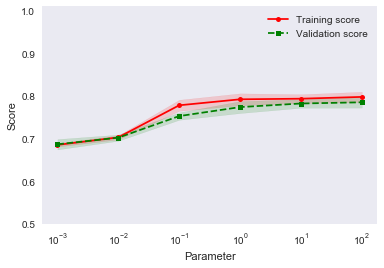

In [495]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train, y=y_train, param_name=param_name,
                      ylim=(0.5, 1.01), param_range=param_range)

* C = 1 seems to be a reasonable choice.

## Learning curve

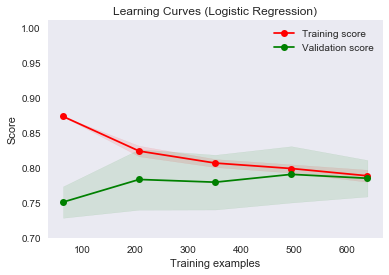

In [496]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

* Initial overfit.
* Final underfit. 
* Lack of stability.
 * Standard deviations are ok.
 * Trend is not uniform.
 * Different random states, different results.
* More data would help.

---

# The chubby data set

* Impute 'Age' missing data
* Bin 'Age' data
* Create feature to identify imputed data
* Combine features
* Clean outliers
* Transform features
* Family Size
* Price per person
* Title (although grouped)

## Age

* Should we bin the data?
 * Yes, if we can see that there are some groups. Justify this based on the links bellow.
 * No, if we
 * Can I create a simple model to test? Like, logistic with age continuous vs. logistic with binned data
 * https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when
 * https://stats.stackexchange.com/questions/68834/what-is-the-benefit-of-breaking-up-a-continuous-predictor-variable
* Impute 'age'
 * Model?
 * Means based on 'Title'
* Test bin
 * Master
 * Incremental imputing
 * Does it worth?
 * How to optimize binning?
* Create feature to identify imputed data 

In [497]:
# Keep original index to recover information if necessary
idx_X_train = X_train.index
idx_y_train = y_train.index

### Test continuous vs. discrete variable

In [498]:
# Remove data with imputed age
idx_age1000 = X_train.loc[X_train['Age'] == 1000].index
X_train.drop(idx_age1000, inplace=True)
y_train.drop(idx_age1000, inplace=True)

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [499]:
# Test model with continuous age
logreg = LogisticRegression()
logreg.fit(X_train['Age'].reshape(X_train['Age'].shape[0],1), y_train)  # Reshape to avoid inconsistent number of samples error
scores = cross_val_score(logreg, X_train['Age'].reshape(X_train['Age'].shape[0],1), y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.603 +/- 0.020


/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [500]:
# Bin age data
X_train['Age'] = pd.cut(X_train['Age'], bins=[0, 14, 60, 200], labels=['Child','Adult','Elder'])
X_train['Age'].head()

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


687    Adult
659    Adult
266    Adult
572    Adult
765    Adult
Name: Age, dtype: category
Categories (3, object): [Adult < Child < Elder]

In [501]:
# Get dummies
X_train['Age'] = pd.Categorical(X_train['Age'])
X_train = pd.get_dummies(X_train)
X_train

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Pclass      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
687       3   10.1708           0         1           0           1   
659       1  113.2750           2         1           0           0   
266       3   39.6875           5         1           0           1   
572       1   26.3875           0         1           0           1   
765       1   77.9583           1         0           0           1   
519       3    7.8958           0         1           0           1   
434       1   55.9000           1         1           0           1   
62        1   83.4750           1         1           0           1   
243       3    7.1250           0         1           0           1   
728       2   26.0000           1         1           0           1   
595       3   24.1500           2         1           0           1   
492       1   30.5000           0         1           0           1   
819       3   27.9000           5         1           0           1   
571       1   51.4792           2         0           0           1   
136       1   26.2833           2         0           0           1   
245       1   90.0000           2         1           1           0   
345       2   13.0000           0         0           0           1   
751       3   12.4750           1         1           0           1   
135       2   15.0458           0         1           0           0   
393       1  113.2750           1         0           0           0   
105       3    7.8958           0         1           0           1   
676       3    8.0500           0         1           0           1   
275       1   77.9583           1         0           0           1   
57        3    7.2292           0         1           0           0   
730       1  211.3375           0         0           0           1   
342       2   13.0000           0         1           0           1   
553       3    7.2250           0         1           0           0   
505       1  108.9000           1         1           0           0   
856       1  164.8667           2         0           0           1   
219       2   10.5000           0         1           0           1   
..      ...       ...         ...       ...         ...         ...   
514       3    7.4958           0         1           0           1   
314       2   26.2500           2         1           0           1   
535       2   26.2500           2         0           0           1   
831       2   18.7500           2         1           0           1   
320       3    7.2500           0         1           0           1   
7         3   21.0750           4         1           0           1   
394       3   16.7000           2         0           0           1   
142       3   15.8500           1         0           0           1   
479       3   12.2875           1         0           0           1   
504       1   86.5000           0         0           0           1   
754       2   65.0000           3         0           0           1   
216       3    7.9250           0         0           0           1   
581       1  110.8833           2         0           0           0   
399       2   12.6500           0         0           0           1   
491       3    7.2500           0         1           0           1   
253       3   16.1000           1         1           0           1   
469       3   19.2583           3         0           0           0   
255       3   15.2458           2         0           0           0   
179       3    0.0000           0         1           0           1   
282       3    9.5000           0         1           0           1   
391       3    7.7958           0         1           0           1   
509       3   56.4958           0         1           0           1   
750       2   23.0000           2         0           0           1   
130       3    7.8958           0         1           0           0   
145       2   36.7500        

In [502]:
# Test model with discrete age
logreg = LogisticRegression()
logreg.fit(X_train[['Age_Adult','Age_Child','Age_Elder']], y_train) 
scores = cross_val_score(logreg, X_train[['Age_Adult','Age_Child','Age_Elder']], y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.631 +/- 0.047


* Discrete data is working better. We will bin the data
* Different binning limits, lead to different results. Using 14 makes sense in terms of accuracy but also in terms of logic (see paper)
* We can try to impute data based on the person's title

### Imputation based on title

In [503]:
# Inspect names
df_raw['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

* The rule seems to be: 'last name' + ',' + 'title' + 'other names'

In [504]:
# Extract titles from name
df['Title']=0
for i in df:
    df['Title']=df_raw['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df.head()

Survived  Pclass   Age     Fare  FamilySize  Sex_male  Embarked_Q  \
0         0       3  22.0   7.2500           1         1           0   
1         1       1  38.0  71.2833           1         0           0   
2         1       3  26.0   7.9250           0         0           0   
3         1       1  35.0  53.1000           1         0           0   
4         0       3  35.0   8.0500           0         1           0   

   Embarked_S Title  
0           1    Mr  
1           0   Mrs  
2           1  Miss  
3           1   Mrs  
4           1    Mr

In [505]:
# Unique titles
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

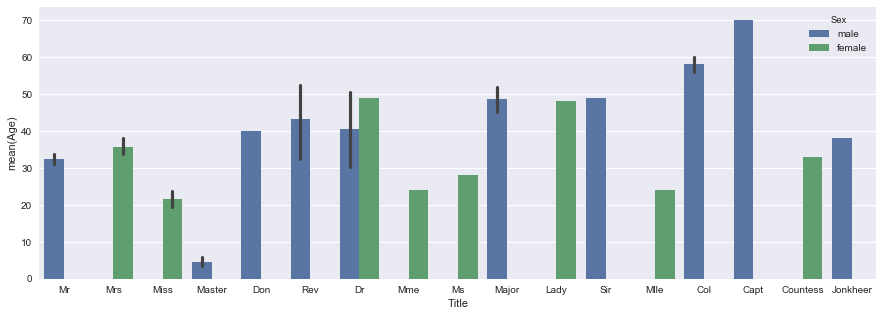

In [506]:
# Titles by age and sex
plt.figure(figsize=(15,5))
sns.barplot(x=df['Title'], y=df_raw['Age'], hue=df_raw['Sex']);

* Titles seem to be a good way to impute age, since, in general, standard deviations are low.
* Mean imputation will be followed. Values to impute will be the mean of the title.

In [507]:
# Means per title
df_raw['Title'] = df['Title']  # To simplify data handling
means = df_raw.groupby('Title')['Age'].mean()
means.head()

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          42.0
Name: Age, dtype: float64

In [508]:
# Transform means into a dictionary for future mapping
map_means = means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.5741666666666667,
 'Miss': 21.662068965517243,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.368090452261306,
 'Mrs': 35.654205607476634,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'Sir': 49.0}

In [509]:
# Titles of the data points where age will be imputed
titles = df_raw['Title'].loc[idx_age1000]
titles.head()

121      Mr
790      Mr
837      Mr
502    Miss
792    Miss
Name: Title, dtype: object

In [510]:
# Restore original training set
X_train = df_raw.loc[idx_X_train]
y_train = df_raw['Survived'].loc[idx_y_train]
X_train.head()

PassengerId  Survived  Pclass                        Name   Sex   Age  \
121          122         0       3  Moore, Mr. Leonard Charles  male   NaN   
687          688         0       3           Dakic, Mr. Branko  male  19.0   
790          791         0       3    Keane, Mr. Andrew "Andy"  male   NaN   
837          838         0       3         Sirota, Mr. Maurice  male   NaN   
659          660         0       1  Newell, Mr. Arthur Webster  male  58.0   

     SibSp  Parch     Ticket      Fare Cabin Embarked Title  
121      0      0  A4. 54510    8.0500   NaN        S    Mr  
687      0      0     349228   10.1708   NaN        S    Mr  
790      0      0      12460    7.7500   NaN        Q    Mr  
837      0      0     392092    8.0500   NaN        S    Mr  
659      0      2      35273  113.2750   D48        C    Mr

In [511]:
# Impute ages based on titles
X_train['Age'].loc[idx_age1000] = X_train['Title'].loc[idx_age1000].map(map_means)
X_train.head()

/Users/macbook/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


PassengerId  Survived  Pclass                        Name   Sex  \
121          122         0       3  Moore, Mr. Leonard Charles  male   
687          688         0       3           Dakic, Mr. Branko  male   
790          791         0       3    Keane, Mr. Andrew "Andy"  male   
837          838         0       3         Sirota, Mr. Maurice  male   
659          660         0       1  Newell, Mr. Arthur Webster  male   

          Age  SibSp  Parch     Ticket      Fare Cabin Embarked Title  
121  32.36809      0      0  A4. 54510    8.0500   NaN        S    Mr  
687  19.00000      0      0     349228   10.1708   NaN        S    Mr  
790  32.36809      0      0      12460    7.7500   NaN        Q    Mr  
837  32.36809      0      0     392092    8.0500   NaN        S    Mr  
659  58.00000      0      2      35273  113.2750   D48        C    Mr

In [512]:
# Bin age data
X_train['Age'] = pd.cut(X_train['Age'], bins=[0, 14, 60, 200], labels=['Child','Adult','Elder'])
X_train['Age'].head()

121    Adult
687    Adult
790    Adult
837    Adult
659    Adult
Name: Age, dtype: category
Categories (3, object): [Adult < Child < Elder]

In [513]:
# Get dummies
X_train['Age'] = pd.Categorical(X_train['Age'])
X_train = pd.get_dummies(X_train)
X_train.head()

PassengerId  Survived  Pclass  SibSp  Parch      Fare  \
121          122         0       3      0      0    8.0500   
687          688         0       3      0      0   10.1708   
790          791         0       3      0      0    7.7500   
837          838         0       3      0      0    8.0500   
659          660         0       1      0      2  113.2750   

     Name_Abbing, Mr. Anthony  Name_Abbott, Mr. Rossmore Edward  \
121                         0                                 0   
687                         0                                 0   
790                         0                                 0   
837                         0                                 0   
659                         0                                 0   

     Name_Abbott, Mrs. Stanton (Rosa Hunt)  Name_Abelson, Mr. Samuel  \
121                                      0                         0   
687                                      0                         0   
790                                      0                         0   
837                                      0                         0   
659                                      0                         0   

       ...      Title_Lady  Title_Major  Title_Master  Title_Miss  Title_Mlle  \
121    ...               0            0             0           0           0   
687    ...               0            0             0           0           0   
790    ...               0            0             0           0           0   
837    ...               0            0             0           0           0   
659    ...               0            0             0           0           0   

     Title_Mr  Title_Mrs  Title_Ms  Title_Rev  Title_Sir  
121         1          0         0          0          0  
687         1          0         0          0          0  
790         1          0         0          0          0  
837         1          0         0          0          0  
659         1          0         0          0          0  

[5 rows x 1437 columns]

In [514]:
# Test model with discrete age
logreg = LogisticRegression()
logreg.fit(X_train[['Age_Adult','Age_Child','Age_Elder']], y_train)  
scores = cross_val_score(logreg, X_train[['Age_Adult','Age_Child','Age_Elder']], y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.651 +/- 0.033


### Test inclusion of missing data feature

In [515]:
# Restore original training set
X_train = df_raw.loc[idx_X_train]
y_train = df_raw['Survived'].loc[idx_y_train]
X_train.head()

PassengerId  Survived  Pclass                        Name   Sex   Age  \
121          122         0       3  Moore, Mr. Leonard Charles  male   NaN   
687          688         0       3           Dakic, Mr. Branko  male  19.0   
790          791         0       3    Keane, Mr. Andrew "Andy"  male   NaN   
837          838         0       3         Sirota, Mr. Maurice  male   NaN   
659          660         0       1  Newell, Mr. Arthur Webster  male  58.0   

     SibSp  Parch     Ticket      Fare Cabin Embarked Title  
121      0      0  A4. 54510    8.0500   NaN        S    Mr  
687      0      0     349228   10.1708   NaN        S    Mr  
790      0      0      12460    7.7500   NaN        Q    Mr  
837      0      0     392092    8.0500   NaN        S    Mr  
659      0      2      35273  113.2750   D48        C    Mr

In [516]:
# Create feature for missing data
X_train['Imputed'] = 0
X_train.head()

PassengerId  Survived  Pclass                        Name   Sex   Age  \
121          122         0       3  Moore, Mr. Leonard Charles  male   NaN   
687          688         0       3           Dakic, Mr. Branko  male  19.0   
790          791         0       3    Keane, Mr. Andrew "Andy"  male   NaN   
837          838         0       3         Sirota, Mr. Maurice  male   NaN   
659          660         0       1  Newell, Mr. Arthur Webster  male  58.0   

     SibSp  Parch     Ticket      Fare Cabin Embarked Title  Imputed  
121      0      0  A4. 54510    8.0500   NaN        S    Mr        0  
687      0      0     349228   10.1708   NaN        S    Mr        0  
790      0      0      12460    7.7500   NaN        Q    Mr        0  
837      0      0     392092    8.0500   NaN        S    Mr        0  
659      0      2      35273  113.2750   D48        C    Mr        0

In [517]:
# Identify imputed data
X_train.set_value(idx_age1000, 'Imputed', 1)
X_train.head()

PassengerId  Survived  Pclass                        Name   Sex   Age  \
121          122         0       3  Moore, Mr. Leonard Charles  male   NaN   
687          688         0       3           Dakic, Mr. Branko  male  19.0   
790          791         0       3    Keane, Mr. Andrew "Andy"  male   NaN   
837          838         0       3         Sirota, Mr. Maurice  male   NaN   
659          660         0       1  Newell, Mr. Arthur Webster  male  58.0   

     SibSp  Parch     Ticket      Fare Cabin Embarked Title  Imputed  
121      0      0  A4. 54510    8.0500   NaN        S    Mr        1  
687      0      0     349228   10.1708   NaN        S    Mr        0  
790      0      0      12460    7.7500   NaN        Q    Mr        1  
837      0      0     392092    8.0500   NaN        S    Mr        1  
659      0      2      35273  113.2750   D48        C    Mr        0

* Let's test for continuous age

In [518]:
# Test continuous age
X_train['Age'].loc[idx_age1000] = X_train['Title'].loc[idx_age1000].map(map_means)

logreg = LogisticRegression()
logreg.fit(X_train[['Age','Imputed']], y_train)
scores = cross_val_score(logreg, X_train[['Age','Imputed']], y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.648 +/- 0.023


/Users/macbook/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


* Model improved
* Let's check with discrete data

In [519]:
# Bin age data
X_train['Age'] = pd.cut(X_train['Age'], bins=[0, 14, 60, 200], labels=['Child','Adult','Elder'])
X_train['Age'].head()

121    Adult
687    Adult
790    Adult
837    Adult
659    Adult
Name: Age, dtype: category
Categories (3, object): [Adult < Child < Elder]

In [520]:
# Identify 'Imputed' as categorical
X_train['Imputed'] = pd.Categorical(X_train['Imputed'])

In [521]:
# Get dummies
X_train['Age'] = pd.Categorical(X_train['Age'])
X_train = pd.get_dummies(X_train)
X_train.head()

PassengerId  Survived  Pclass  SibSp  Parch      Fare  \
121          122         0       3      0      0    8.0500   
687          688         0       3      0      0   10.1708   
790          791         0       3      0      0    7.7500   
837          838         0       3      0      0    8.0500   
659          660         0       1      0      2  113.2750   

     Name_Abbing, Mr. Anthony  Name_Abbott, Mr. Rossmore Edward  \
121                         0                                 0   
687                         0                                 0   
790                         0                                 0   
837                         0                                 0   
659                         0                                 0   

     Name_Abbott, Mrs. Stanton (Rosa Hunt)  Name_Abelson, Mr. Samuel  \
121                                      0                         0   
687                                      0                         0   
790                                      0                         0   
837                                      0                         0   
659                                      0                         0   

       ...      Title_Master  Title_Miss  Title_Mlle  Title_Mr  Title_Mrs  \
121    ...                 0           0           0         1          0   
687    ...                 0           0           0         1          0   
790    ...                 0           0           0         1          0   
837    ...                 0           0           0         1          0   
659    ...                 0           0           0         1          0   

     Title_Ms  Title_Rev  Title_Sir  Imputed_0  Imputed_1  
121         0          0          0          0          1  
687         0          0          0          1          0  
790         0          0          0          0          1  
837         0          0          0          0          1  
659         0          0          0          1          0  

[5 rows x 1439 columns]

In [522]:
# Test model with discrete age
logreg = LogisticRegression()
logreg.fit(X_train[['Age_Adult','Age_Child','Age_Elder','Imputed_0','Imputed_1']], y_train)  
scores = cross_val_score(logreg, X_train[['Age_Adult','Age_Child','Age_Elder','Imputed_0','Imputed_1']], \
                         y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.650 +/- 0.033


* Models behave more or less equally. The one that has better performance is with binned data, without imputed features. That's the one that I'll use.
* I need to impute when I'm modelling to avoid data leakages.

# Combine features

* Correlation analysis
* Does any statistical relationship make sense?

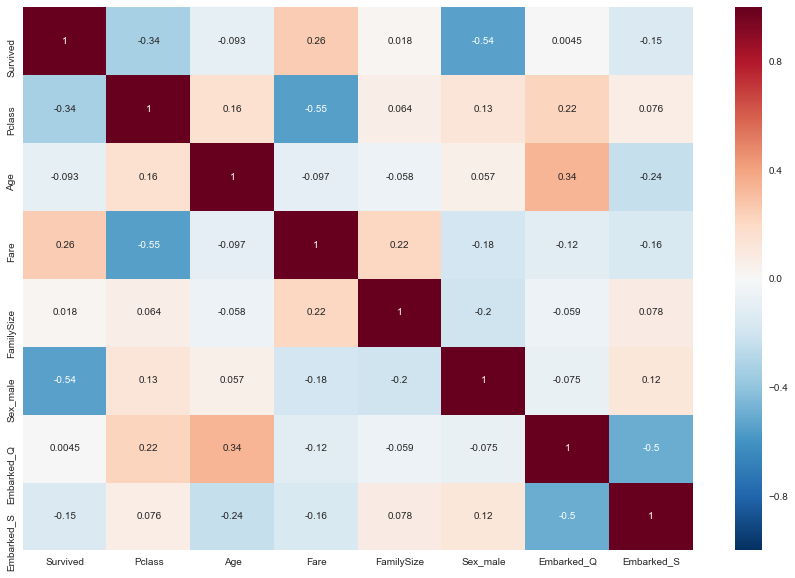

In [523]:
# Check correlations
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True);

* 'Fare' and 'Pclass' have a strong correlation. I'll try to combine them.
* The correlation is negative. Maybe the ratio makes more sense then the multiplication.

In [524]:
# Create new feature
df['Fare_Pclass'] = df['Fare'] / df['Pclass']
df.head()

Survived  Pclass   Age     Fare  FamilySize  Sex_male  Embarked_Q  \
0         0       3  22.0   7.2500           1         1           0   
1         1       1  38.0  71.2833           1         0           0   
2         1       3  26.0   7.9250           0         0           0   
3         1       1  35.0  53.1000           1         0           0   
4         0       3  35.0   8.0500           0         1           0   

   Embarked_S Title  Fare_Pclass  
0           1    Mr     2.416667  
1           0   Mrs    71.283300  
2           1  Miss     2.641667  
3           1   Mrs    53.100000  
4           1    Mr     2.683333

In [525]:
# Test correlation
df.corr()['Survived']

Survived       1.000000
Pclass        -0.335549
Age           -0.093407
Fare           0.255290
FamilySize     0.018277
Sex_male      -0.541585
Embarked_Q     0.004536
Embarked_S    -0.151777
Fare_Pclass    0.265392
Name: Survived, dtype: float64

In [526]:
# Transform new feature using Box-Cox transformation
df['Fare_Pclass'] = stats.boxcox(df['Fare_Pclass']+1)[0]
df.head()

Survived  Pclass   Age     Fare  FamilySize  Sex_male  Embarked_Q  \
0         0       3  22.0   7.2500           1         1           0   
1         1       1  38.0  71.2833           1         0           0   
2         1       3  26.0   7.9250           0         0           0   
3         1       1  35.0  53.1000           1         0           0   
4         0       3  35.0   8.0500           0         1           0   

   Embarked_S Title  Fare_Pclass  
0           1    Mr     1.002768  
1           0   Mrs     2.244980  
2           1  Miss     1.044172  
3           1   Mrs     2.174728  
4           1    Mr     1.051464

In [527]:
# Test correlation
df.corr()['Survived']

Survived       1.000000
Pclass        -0.335549
Age           -0.093407
Fare           0.255290
FamilySize     0.018277
Sex_male      -0.541585
Embarked_Q     0.004536
Embarked_S    -0.151777
Fare_Pclass    0.349349
Name: Survived, dtype: float64

* We will keep it with the transformation
* We will only transform later to avoid leakage
* Logistic regression, so doesn't make sense to use this kind of analysis to establish new features
* Just say that it would make sense to have a relationship between both. Later we will se that Fare only adds noise

# Improved model

In [528]:
# Restore data set
df['Age'] = df_raw['Age']
df.drop('Fare_Pclass', axis=1, inplace=True)
df.head()

Survived  Pclass   Age     Fare  FamilySize  Sex_male  Embarked_Q  \
0         0       3  22.0   7.2500           1         1           0   
1         1       1  38.0  71.2833           1         0           0   
2         1       3  26.0   7.9250           0         0           0   
3         1       1  35.0  53.1000           1         0           0   
4         0       3  35.0   8.0500           0         1           0   

   Embarked_S Title  
0           1    Mr  
1           0   Mrs  
2           1  Miss  
3           1   Mrs  
4           1    Mr

In [529]:
# Create data set to train data imputation methods
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
X_train.head()

Pclass   Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3   NaN    8.0500           0         1           0           1   
687       3  19.0   10.1708           0         1           0           1   
790       3   NaN    7.7500           0         1           1           0   
837       3   NaN    8.0500           0         1           0           1   
659       1  58.0  113.2750           2         1           0           0   

    Title  
121    Mr  
687    Mr  
790    Mr  
837    Mr  
659    Mr

In [530]:
# Means per title
means = X_train.groupby('Title')['Age'].mean()
means.head()

Title
Capt        70.00
Col         58.00
Countess    33.00
Don         40.00
Dr          42.75
Name: Age, dtype: float64

* Maybe add age as well?

In [531]:
# Transform means into a dictionary for future mapping
map_means = means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.75,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 3.9882142857142857,
 'Miss': 21.722972972972972,
 'Mlle': 24.0,
 'Mr': 32.455384615384617,
 'Mrs': 35.770114942528735,
 'Ms': 28.0,
 'Rev': 40.75,
 'Sir': 49.0}

In [532]:
# Index of observations with missing age
idx_missingAge = X_train[X_train['Age'].isnull()].index
idx_missingAge

Int64Index([121, 790, 837, 502, 792, 186, 711, 718, 598,  46,
            ...
            388, 457,  87, 563, 669, 358, 277, 584, 849, 768],
           dtype='int64', length=139)

In [533]:
# Impute age based on 'Title'
X_train['Age'].loc[idx_missingAge] = X_train['Title'].loc[idx_missingAge].map(map_means)
X_train.head()

/Users/macbook/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Pclass        Age      Fare  FamilySize  Sex_male  Embarked_Q  \
121       3  32.455385    8.0500           0         1           0   
687       3  19.000000   10.1708           0         1           0   
790       3  32.455385    7.7500           0         1           1   
837       3  32.455385    8.0500           0         1           0   
659       1  58.000000  113.2750           2         1           0   

     Embarked_S Title  
121           1    Mr  
687           1    Mr  
790           0    Mr  
837           1    Mr  
659           0    Mr

In [534]:
# Bin age data
X_train['Age'] = pd.cut(X_train['Age'], bins=[0, 14, 60, 200], labels=['Child','Adult','Elder'])
X_train['Age'].head()

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


121    Adult
687    Adult
790    Adult
837    Adult
659    Adult
Name: Age, dtype: category
Categories (3, object): [Adult < Child < Elder]

In [535]:
# Identify imputed data
X_train['Imputed'] = 0
X_train.set_value(idx_missingAge, 'Imputed', 1)
X_train.head()

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/macbook/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Pclass    Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3  Adult    8.0500           0         1           0           1   
687       3  Adult   10.1708           0         1           0           1   
790       3  Adult    7.7500           0         1           1           0   
837       3  Adult    8.0500           0         1           0           1   
659       1  Adult  113.2750           2         1           0           0   

    Title  Imputed  
121    Mr        1  
687    Mr        0  
790    Mr        1  
837    Mr        1  
659    Mr        0

In [536]:
# Create new feature
X_train['Fare_Pclass'] = X_train['Fare'] / X_train['Pclass']
X_train.head()

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Pclass    Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3  Adult    8.0500           0         1           0           1   
687       3  Adult   10.1708           0         1           0           1   
790       3  Adult    7.7500           0         1           1           0   
837       3  Adult    8.0500           0         1           0           1   
659       1  Adult  113.2750           2         1           0           0   

    Title  Imputed  Fare_Pclass  
121    Mr        1     2.683333  
687    Mr        0     3.390267  
790    Mr        1     2.583333  
837    Mr        1     2.683333  
659    Mr        0   113.275000

In [537]:
# Transform new feature using Box-Cox
X_train['Fare_Pclass'] = stats.boxcox(X_train['Fare_Pclass']+1)[0]  # Add value to get only positive data
X_train.head()

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Pclass    Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3  Adult    8.0500           0         1           0           1   
687       3  Adult   10.1708           0         1           0           1   
790       3  Adult    7.7500           0         1           1           0   
837       3  Adult    8.0500           0         1           0           1   
659       1  Adult  113.2750           2         1           0           0   

    Title  Imputed  Fare_Pclass  
121    Mr        1     1.040987  
687    Mr        0     1.147487  
790    Mr        1     1.023672  
837    Mr        1     1.040987  
659    Mr        0     2.275897

In [538]:
# Categorical features
X_train['Age'] = pd.Categorical(X_train['Age'])
X_train['Imputed'] = pd.Categorical(X_train['Imputed'])
X_train.dtypes

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Pclass            int64
Age            category
Fare            float64
FamilySize        int64
Sex_male          uint8
Embarked_Q        uint8
Embarked_S        uint8
Title            object
Imputed        category
Fare_Pclass     float64
dtype: object

In [539]:
# List unique titles
X_train['Title'].unique()

array(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Capt',
       'Lady', 'Don', 'Sir', 'Ms', 'Col', 'Jonkheer', 'Countess'], dtype=object)

You will notice that each name has a title in it ! This can be a simple Miss. or Mrs. but it can be sometimes something more sophisticated like Master, Sir or Dona. In that case, we might introduce an additional information about the social status by simply parsing the name and extracting the title.

Let's create title according to social status:
Officer
Royalty
Mr
Mrs
Miss
Master

References: https://forum.wordreference.com/threads/m-mme-mlle.2272213/, https://www.thebalance.com/when-to-use-miss-mrs-or-ms-3514830

In [540]:
X_train.head()

Pclass    Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3  Adult    8.0500           0         1           0           1   
687       3  Adult   10.1708           0         1           0           1   
790       3  Adult    7.7500           0         1           1           0   
837       3  Adult    8.0500           0         1           0           1   
659       1  Adult  113.2750           2         1           0           0   

    Title Imputed  Fare_Pclass  
121    Mr       1     1.040987  
687    Mr       0     1.147487  
790    Mr       1     1.023672  
837    Mr       1     1.040987  
659    Mr       0     2.275897

In [541]:
# Map of aggregated titles:
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Royalty'}

In [542]:
# Group titles
X_train['Title'] = X_train['Title'].map(titles_dict)
X_train['Title']

/Users/macbook/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


121        Mr
687        Mr
790        Mr
837        Mr
659        Mr
266        Mr
502      Miss
792      Miss
186       Mrs
572        Mr
765       Mrs
519        Mr
434        Mr
62         Mr
243        Mr
728        Mr
595        Mr
492        Mr
819    Master
571       Mrs
711        Mr
136      Miss
245     Other
345      Miss
751    Master
135        Mr
393      Miss
105        Mr
676        Mr
275      Miss
        ...  
87         Mr
479      Miss
504      Miss
754       Mrs
216      Miss
581       Mrs
563        Mr
399       Mrs
669       Mrs
491        Mr
253        Mr
469      Miss
358      Miss
255       Mrs
277        Mr
179        Mr
282        Mr
391        Mr
509        Mr
750      Miss
584        Mr
130        Mr
145        Mr
849       Mrs
646        Mr
716      Miss
768        Mr
73         Mr
236        Mr
37         Mr
Name: Title, Length: 711, dtype: object

In [543]:
X_train.head()

Pclass    Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3  Adult    8.0500           0         1           0           1   
687       3  Adult   10.1708           0         1           0           1   
790       3  Adult    7.7500           0         1           1           0   
837       3  Adult    8.0500           0         1           0           1   
659       1  Adult  113.2750           2         1           0           0   

    Title Imputed  Fare_Pclass  
121    Mr       1     1.040987  
687    Mr       0     1.147487  
790    Mr       1     1.023672  
837    Mr       1     1.040987  
659    Mr       0     2.275897

In [544]:
# Bin FamilySize data
#X_train['FamilySize'] = pd.cut(X_train['FamilySize'], bins=[-10, 0, 4, 200], labels=['Single','Small','Large'])
#X_train['FamilySize'].head()

In [545]:
# Transform into categorical
#X_train['FamilySize'] = pd.Categorical(X_train['FamilySize'])
#X_train.dtypes

In [546]:
# Categorize Pclass
#X_train['Pclass'] = pd.Categorical(X_train['Pclass'])

In [547]:
# Dummy variables
X_train = pd.get_dummies(X_train)
X_train.head()

Pclass      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S  \
121       3    8.0500           0         1           0           1   
687       3   10.1708           0         1           0           1   
790       3    7.7500           0         1           1           0   
837       3    8.0500           0         1           0           1   
659       1  113.2750           2         1           0           0   

     Fare_Pclass  Age_Adult  Age_Child  Age_Elder  Title_Master  Title_Miss  \
121     1.040987          1          0          0             0           0   
687     1.147487          1          0          0             0           0   
790     1.023672          1          0          0             0           0   
837     1.040987          1          0          0             0           0   
659     2.275897          1          0          0             0           0   

     Title_Mr  Title_Mrs  Title_Other  Title_Royalty  Imputed_0  Imputed_1  
121         1          0            0              0          0          1  
687         1          0            0              0          1          0  
790         1          0            0              0          0          1  
837         1          0            0              0          0          1  
659         1          0            0              0          1          0

In [548]:
# List columns
X_train.columns.unique()

Index(['Pclass', 'Fare', 'FamilySize', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Fare_Pclass', 'Age_Adult', 'Age_Child', 'Age_Elder', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Title_Royalty',
       'Imputed_0', 'Imputed_1'],
      dtype='object')

In [549]:
# Drop columns to avoid dummy variable trap
#X_train.drop(['Age_Adult','Title_Master','Imputed_0', 'FamilySize_Large'], axis=1, inplace=True)
X_train.drop(['Age_Adult','Title_Master','Imputed_0'], axis=1, inplace=True)
X_train.columns.unique()

Index(['Pclass', 'Fare', 'FamilySize', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Fare_Pclass', 'Age_Child', 'Age_Elder', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other', 'Title_Royalty', 'Imputed_1'],
      dtype='object')

In [550]:
'''
# Normalize data set
from sklearn import preprocessing

columns = X_train.columns.values
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns)
X_train
'''

'\n# Normalize data set\nfrom sklearn import preprocessing\n\ncolumns = X_train.columns.values\nmin_max_scaler = preprocessing.MinMaxScaler()\nX_train = min_max_scaler.fit_transform(X_train)\nX_train = pd.DataFrame(X_train, columns=columns)\nX_train\n'

In [551]:
'''
# Normalize data set
columns = X_train.columns.values
X_train = preprocessing.normalize(X_train, norm='l2')
X_train = pd.DataFrame(X_train, columns=columns)
X_train
'''

"\n# Normalize data set\ncolumns = X_train.columns.values\nX_train = preprocessing.normalize(X_train, norm='l2')\nX_train = pd.DataFrame(X_train, columns=columns)\nX_train\n"

In [552]:
'''
# Create different data sets

train_cols_01 = ['Pclass',
                 'Fare','Sex_male','Embarked_Q','Embarked_S','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_02 = ['Pclass',
                 'Sex_male','Embarked_Q','Embarked_S','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_03 = ['Fare','Sex_male','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_04 = ['Fare_Pclass',
                 'Sex_male','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_05 = ['Pclass',
                 'Fare','Sex_male','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train_cols_06 = ['Pclass',
                 'Sex_male','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train_cols_07 = ['Fare','Sex_male','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train_cols_08 = ['Fare_Pclass',
                 'Sex_male','FamilySize_Single', 'FamilySize_Small',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train = [train_cols_01, train_cols_02, train_cols_03, train_cols_04, train_cols_05, train_cols_06,
         train_cols_07, train_cols_08]
'''

"\n# Create different data sets\n\ntrain_cols_01 = ['Pclass',\n                 'Fare','Sex_male','Embarked_Q','Embarked_S','FamilySize_Single', 'FamilySize_Small',\n                 'Age_Child','Age_Elder',\n                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']\ntrain_cols_02 = ['Pclass',\n                 'Sex_male','Embarked_Q','Embarked_S','FamilySize_Single', 'FamilySize_Small',\n                 'Age_Child','Age_Elder',\n                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']\ntrain_cols_03 = ['Fare','Sex_male','FamilySize_Single', 'FamilySize_Small',\n                 'Age_Child','Age_Elder',\n                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']\ntrain_cols_04 = ['Fare_Pclass',\n                 'Sex_male','FamilySize_Single', 'FamilySize_Small',\n                 'Age_Child','Age_Elder',\n                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other',

In [553]:
# Create different data sets
train_cols_01 = ['Pclass',
                 'Fare','Sex_male','Embarked_Q','Embarked_S','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_02 = ['Pclass',
                 'Sex_male','Embarked_Q','Embarked_S','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_03 = ['Fare','Sex_male','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_04 = ['Fare_Pclass',
                 'Sex_male','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty','Imputed_1']
train_cols_05 = ['Pclass',
                 'Fare','Sex_male','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train_cols_06 = ['Pclass',
                 'Sex_male','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train_cols_07 = ['Fare','Sex_male','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train_cols_08 = ['Fare_Pclass',
                 'Sex_male','FamilySize',
                 'Age_Child','Age_Elder',
                 'Title_Miss','Title_Mr','Title_Mrs','Title_Other','Title_Royalty']
train = [train_cols_01, train_cols_02, train_cols_03, train_cols_04, train_cols_05, train_cols_06,
         train_cols_07, train_cols_08]

In [554]:
scores = []
stds = []
for i in train:
    logreg = LogisticRegression()
    logreg.fit(X_train[i], y_train)
    score = cross_val_score(logreg, X_train[i], y_train, cv=10)
    scores.append(np.mean(score))
    stds.append(np.std(score))
scores

[0.81862284820031284,
 0.81715515314106857,
 0.81017046724793196,
 0.81999049854683648,
 0.812929242119383,
 0.81850324167225563,
 0.81437625754527154,
 0.81719371786273187]

* xxx

In [555]:
# Select features
X_train = X_train[train_cols_04]
X_train.head()

Fare_Pclass  Sex_male  FamilySize  Age_Child  Age_Elder  Title_Miss  \
121     1.040987         1           0          0          0           0   
687     1.147487         1           0          0          0           0   
790     1.023672         1           0          0          0           0   
837     1.040987         1           0          0          0           0   
659     2.275897         1           2          0          0           0   

     Title_Mr  Title_Mrs  Title_Other  Title_Royalty  Imputed_1  
121         1          0            0              0          1  
687         1          0            0              0          0  
790         1          0            0              0          1  
837         1          0            0              0          1  
659         1          0            0              0          0

In [556]:
# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [557]:
# Model performance
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.820 +/- 0.036


## Validation curve

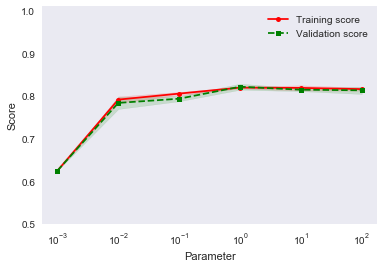

In [558]:
# Plot validation curve
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
cv = 10
plot_validation_curve(estimator=logreg, title=title, X=X_train, y=y_train, param_name=param_name,
                      ylim=(0.5, 1.01), param_range=param_range)

* C = 1 seems to be a reasonable choice.

## Learning curve

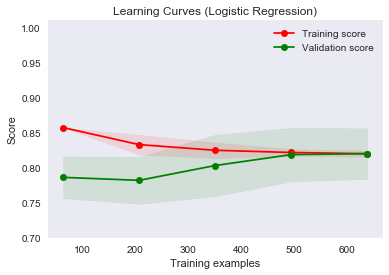

In [559]:
# Plot learning curves
title = "Learning Curves (Logistic Regression)"
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim=(0.7, 1.01), cv=10, n_jobs=1);

* When YY has limited information (e.g., is binary or is categorical but unordered), overfitting is more severe just because whenever you have low information it is like having a smaller sample size. For example a sample of size 100 from a continuous YY may have the same information as a sample of size 250 from a binary YY, for the purposes of statistical power, precision, and overfitting. Binary YY assumes an all-or-nothing phenomenon and has 1 bit of information. Many continuous variables have at least 5 bits of information.

# Ensemble

xxx

In [560]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [9, 10, 11],
          'randomforestclassifier__n_estimators': [10,50],
          'meta-logisticregression__C': [10, 100]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=10,
                    refit=True)
grid.fit(X_train.values, y_train.values)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r],
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.3f' % grid.best_score_)

0.819 +/- 0.04 {'kneighborsclassifier__n_neighbors': 9, 'meta-logisticregression__C': 10, 'randomforestclassifier__n_estimators': 10}
0.816 +/- 0.04 {'kneighborsclassifier__n_neighbors': 9, 'meta-logisticregression__C': 10, 'randomforestclassifier__n_estimators': 50}
0.816 +/- 0.04 {'kneighborsclassifier__n_neighbors': 9, 'meta-logisticregression__C': 100, 'randomforestclassifier__n_estimators': 10}
0.817 +/- 0.03 {'kneighborsclassifier__n_neighbors': 9, 'meta-logisticregression__C': 100, 'randomforestclassifier__n_estimators': 50}
0.821 +/- 0.04 {'kneighborsclassifier__n_neighbors': 10, 'meta-logisticregression__C': 10, 'randomforestclassifier__n_estimators': 10}
0.819 +/- 0.04 {'kneighborsclassifier__n_neighbors': 10, 'meta-logisticregression__C': 10, 'randomforestclassifier__n_estimators': 50}
0.821 +/- 0.04 {'kneighborsclassifier__n_neighbors': 10, 'meta-logisticregression__C': 100, 'randomforestclassifier__n_estimators': 10}
0.817 +/- 0.04 {'kneighborsclassifier__n_neighbors': 10,

# Auto-sklearn

In [561]:
'''
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
X, y = sklearn.datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))
'''

'\nimport autosklearn.classification\nimport sklearn.model_selection\nimport sklearn.datasets\nimport sklearn.metrics\nX, y = sklearn.datasets.load_digits(return_X_y=True)\nX_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)\nautoml = autosklearn.classification.AutoSklearnClassifier()\nautoml.fit(X_train, y_train)\ny_hat = automl.predict(X_test)\nprint("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))\n'

---

# Annex

## Code tests

xxx

P: Strange results can make us be unsure about our code.

S: Use cases where you know the results to check your code.

### Learning curve

<module 'matplotlib.pyplot' from '/Users/macbook/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

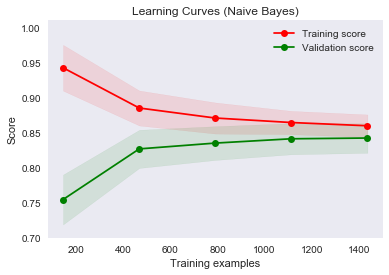

In [562]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit

digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

* Code is ok. It matches the plot shown in http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

### Validation curve

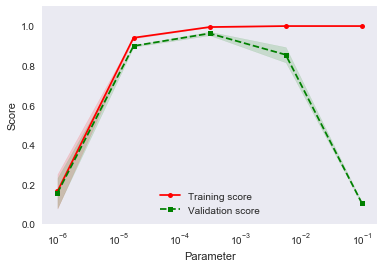

In [563]:
from sklearn.svm import SVC

digits = load_digits()
X, y = digits.data, digits.target

title = 'Validation Curve with SVM'
param_name="gamma"
param_range = np.logspace(-6, -1, 5)
cv = 10
plot_validation_curve(estimator= SVC(), title=title, X=X, y=y, param_name=param_name,
                      ylim=(0.0, 1.1), param_range=param_range)

* Code is ok. It matches plot shown in http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py